In [1]:
# This notebook analyse candidate genes
# Author: Yiyun
import pandas as pd
import os
from os import listdir
from os.path import join
import pickle
import seaborn as sns
from scipy.stats import mannwhitneyu
from multiprocessing import Pool
import matplotlib.pyplot as plt

In [13]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib import gridspec
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'lines.linewidth':3,
         'font.sans-serif':'Ariel',
          'font.size':10}
# font = {'fontname':'monospace', 'size':'15'}
pylab.rcParams.update(params)

In [2]:
### Directories
# Read expression data
exp_dir = '../anno_ref/icgc/pcawg_rnaseq/'
gene_tophatuq = 'tophat_star_fpkm_uq.v2_aliquot_gl.tsv'
gene_tophat = 'tophat_star_fpkm.v2.aliquot_gl.tsv'

maf_dir = '../org_cov_maf'

In [3]:
### Read expression data
# Read aliquot id information
df_exp_info = pd.read_csv(join(exp_dir,'rnaseq.metadata.tsv'), sep = '\t')
# Read expression information
df_exp_uq = pd.read_csv(join(exp_dir,gene_tophatuq),sep = '\t', index_col = 0)
df_exp = pd.read_csv(join(exp_dir,gene_tophat),sep = '\t', index_col = 0)
# Read organ-aliquot id list
dict_tumor = pickle.load(open('./pcawg_exp/tumor_aliquotid_dict.pkl','rb'))
# Get list of major tumor organs (not myeloid result)
list_org = []
for tumors in dict_tumor:
    org = tumors.split('-')[0]
    if org not in list_org: list_org.append(org) 

In [5]:
###------------Functions----------
# Get gene from expression data
def get_gene_exp(gene_id, df_expression):
    df = df_expression.loc[df_expression.index.str.contains(rf'^{gene_id}'),:]
    
    return df

# Get patients with silent mutations
def get_cancer_patients(organ, gene_name, subtype = None):
    df_maf= pd.read_csv(join(maf_dir,organ,'merged_tumor_covmerged_'+organ+'.txt_filtered.maf'),sep = '\t')
    df_gene = df_maf[df_maf['Hugo_Symbol'] == gene_name]
    df_gene_syn = df_gene[df_gene['Variant_Classification'] == 'Silent']

    ### Filter for specific tumor type
    if subtype:
        patients = df_gene_syn[df_gene_syn['Project_Code'] == subtype]['Donor_ID'].unique().tolist()
    else:
        patients = df_gene_syn['Donor_ID'].unique().tolist()
    print(patients)
    
    ### Check if patients have other mutations
    l_drop =[]
    for p in patients:
        df_donor = df_gene[df_gene['Donor_ID'] == p]
        print(df_donor['Variant_Classification'].unique())
        if any(i in df_donor['Variant_Classification'].unique() for i in ['Missense_Mutation', 'Nonsense_Mutation','Splice_Site', 'Nonstop_Mutation','Start_Codon_SNP']):
            l_drop.append(p)
    for i in l_drop:
        patients.remove(i)
        
    print(patients)

    return patients,df_gene_syn

# get patient expressions
def get_patient_exp(ids, df_gene_exp, tissue_type = None):
    df_for_test = df_gene_exp[ids].transpose()
    df = df_gene_exp[ids].transpose().reset_index()
    df['tumor.normal'] = tissue_type
    df.columns = ['id','exp','tumor.normal']
    
    return df, df_for_test

# Get normal, syn, other patient aliquot id
def get_patient_id(organ, patients, subtype = None):
    global df_exp_info
    
    if subtype:
        df = df_exp_info[df_exp_info['histology_abbreviation'] == subtype]
    else:
        df = df_exp_info[df_exp_info['histology_abbreviation'].str.startswith(organ)]
    
    # Get tumor, syn and normal patient aliquot id
    normal_id = df[df['tumor.normal'] == 'normal']['aliquot_id']
    df_tumor = df[df['tumor.normal'] == 'tumor']
    tumor_syn_id = df_tumor[df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    tumor_other_id = df_tumor[~df_tumor['icgc_donor_id'].isin(patients)]['aliquot_id']
    
    return normal_id, tumor_syn_id, tumor_other_id

In [6]:
### Get candidates -- The genes is get and transform to gene id in R
pivot_syn = './res/pivot_syn_May-27-2021.csv'
pivot_nsyn = './res/pivot_nsyn_May-27-2021.csv'
df_pivot_syn = pd.read_csv(pivot_syn)
df_pivot_nsyn = pd.read_csv(pivot_nsyn)

# sig_syn = df_pivot_syn['gene'][0:-1]
# sig_syn.to_csv('./res/final_syn_candidates.csv')

df_pivot_syn = df_pivot_syn.set_index('gene')

In [7]:
### Read gene file
sig_genes_syn = pd.read_csv('./res/final_syn_candidates_name_id.csv', index_col = 0)
sig_genes_syn.columns = ['gene_name','gene_id']

In [ ]:
### Get genes, organ types they are significant in
def plot_test(i):
    global sig_genes_syn
    gene_name = sig_genes_syn.loc[i,'gene_name']
    gene_id  = sig_genes_syn.loc[i,'gene_id']
    
    sig_tumors = df_pivot_syn.loc[gene_name,:].dropna().index.tolist()
    for organ_type in sig_tumors:
        gene_id = gene_id
        gene_name = gene_name
        organ_type = organ_type
        organ_subtype = None
        df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
        syn_patients, syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
        id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


        # Get expression and combine tumor, syn and normal df
        df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
        df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
        df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
        df_all = pd.concat([df_normal,df_syn,df_other])

        fig,ax = plt.subplots(figsize=(10,6))
        ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
        
        mannwhitneyu(syn_test, other_test)
        text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
#         ax.text(1, 0.9, text, fontsize=12, va='top')
        ax.set_title(organ_type+'_'+gene_name+'_'+text)
        plt.savefig('./res/'+organ_type+'_'+gene_name+'.png')
        
        if (mannwhitneyu(syn_test, other_test)[1] < 0.05) and (mannwhitneyu(syn_test, other_test)[0]>0):
            print(organ_type)
            print(gene_name)
        

p = Pool(12)
res = p.map(plot_test, range(0,len(sig_genes_syn)))
p.close()
p.join()

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (17,24) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/scipy/stats/stats.py:7039: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (1,17,24,33,34,35,36)

Head
ACSM3


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (17,24) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (17,24) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/scipy/stats/stats.py:7039: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/scipy/stats/stats.py:7039: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (17,24) have mixed types.Specify dtype option on import

Kidney
VCAN


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (1,17,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/scipy/stats/stats.py:7039: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (1,17,24,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/scipy/stats/stats.py:7039: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/multiprocessing/pool.py:125: DtypeWarning: Columns (1,17,24,28,33,34,35,36) have 

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,17,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


['DO20082', 'DO19733', 'DO48495']
['Silent']
['Silent']
['Silent']
['DO20082', 'DO19733', 'DO48495']
                                     id         exp tumor.normal
0  7694eaf3-732e-4b23-b8fe-ce713c1a4b18   18.298739    tumor_syn
1  29739602-d94f-4341-849e-a5b8a4c342eb  110.871777    tumor_syn
2  536d11ba-aa02-4443-96e8-6e9e9898ceb7   21.832894    tumor_syn


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/matplotlib/patches.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd, dy / dd
/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/matplotlib/patches.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd, dy / dd


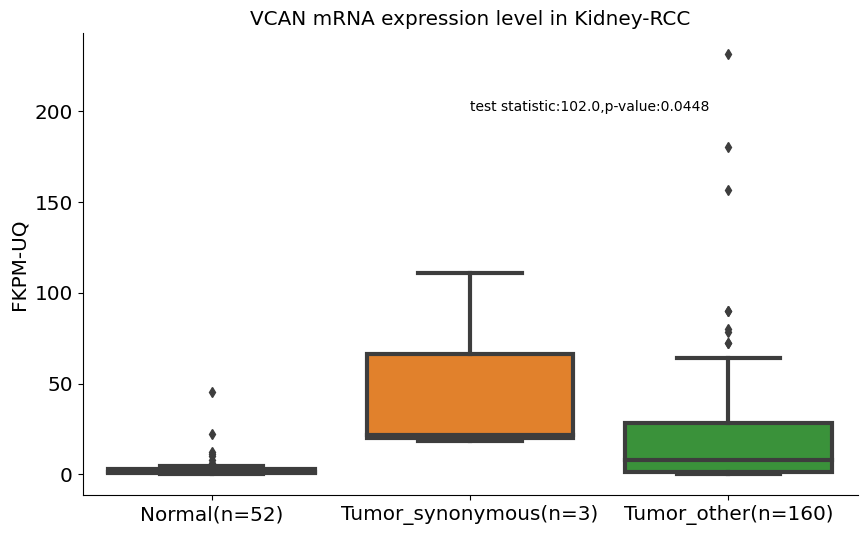

In [16]:
### Parameter card
### Parameter card
gene_name = 'VCAN'
gene_id = sig_genes_syn.loc[sig_genes_syn[sig_genes_syn['gene_name'] == gene_name].index,'gene_id'].tolist()[0]

organ_type = 'Kidney'
organ_subtype = None
df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
syn_patients, syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


# Get expression and combine tumor, syn and normal df
df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_syn,df_other])
print(df_syn)

fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
ax.set_title(organ_type+'_'+gene_name)
mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.set_xticklabels([f'Normal(n={len(normal_test)})', f'Tumor_synonymous(n={len(syn_test)})', f'Tumor_other(n={len(other_test)})'])
ax.set_xlabel('')
ax.set_ylabel('FKPM-UQ')
ax.set_title(gene_name+' mRNA expression level in Kidney-RCC')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
ax.annotate(text, xy=(1,200), zorder=10)
ax.annotate('', xy=(1,2), xytext=(1,2), arrowprops=props)
plt.savefig(os.path.join('figure6', 'VCAN.pdf'))

In [39]:
syn_mut_df

,Hugo_Symbol,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,...,i_signature_R1,i_signature_R2,i_snv_near_indel,t_alt_count,t_ref_count,i_model_score,i_n_vaf,Project_Code,Donor_ID,categ
69670,VCAN,5,82834030,82834030,+,Silent,SNP,T,T,A,...,False,False,False,13.0,61.0,NaN,NaN,Kidney-RCC,DO20082,6
104751,VCAN,5,82834255,82834255,+,Silent,SNP,T,T,C,...,False,False,False,17.0,29.0,NaN,NaN,Kidney-RCC,DO19733,5
369293,VCAN,5,82815685,82815685,+,Silent,SNP,G,G,A,...,False,False,False,31.0,59.0,NaN,NaN,Kidney-RCC,DO48495,3


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,17,24,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


['Silent']
['Silent']
['Silent']
                                     id       exp tumor.normal
0  898aa183-162f-47a6-b564-4708b5dabdd0  0.097807    tumor_syn
1  30dc1f2d-9d27-4c6d-830a-0947bcf79cd0  0.118117    tumor_syn
2  89e229a4-ecbc-486b-bf2c-8e58d21fd17b  0.027342    tumor_syn


Text(1, 2, '')

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/matplotlib/patches.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd, dy / dd


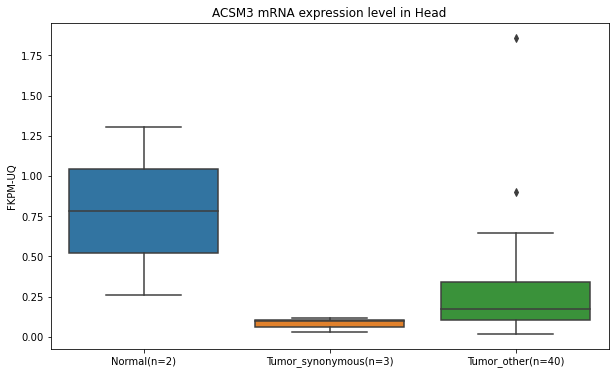

In [46]:
### Parameter card
gene_id = 'ENSG00000005187'
gene_name = 'ACSM3'
organ_type = 'Head'
organ_subtype = None
df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
syn_patients,syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


# Get expression and combine tumor, syn and normal df
df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_syn,df_other])
print(df_syn)

fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
ax.set_title(organ_type+'_'+gene_name)
mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.set_xticklabels([f'Normal(n={len(normal_test)})', f'Tumor_synonymous(n={len(syn_test)})', f'Tumor_other(n={len(other_test)})'])
ax.set_xlabel('')
ax.set_ylabel('FKPM-UQ')
ax.set_title(gene_name+' mRNA expression level in '+organ_type)
props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
ax.annotate(text, xy=(1,2), zorder=10)
ax.annotate('', xy=(1,2), xytext=(1,2), arrowprops=props)

In [26]:
syn_mut_df

,Hugo_Symbol,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,...,i_signature_R1,i_signature_R2,i_snv_near_indel,t_alt_count,t_ref_count,i_model_score,i_n_vaf,Project_Code,Donor_ID,categ
278321,ACSM3,16,20797459,20797459,+,Silent,SNP,T,T,G,...,False,False,False,19.0,46.0,NaN,NaN,Head-SCC,DO15815,6
485006,ACSM3,16,20781491,20781491,+,Silent,SNP,C,C,T,...,False,False,False,28.0,35.0,NaN,NaN,Head-SCC,DO14192,3
703220,ACSM3,16,20787221,20787221,+,Silent,SNP,C,C,A,...,False,False,False,29.0,29.0,NaN,NaN,Head-SCC,DO14502,2


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,17,24,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


['DO28093', 'DO28273', 'DO46328']
['Silent' 'Intron']
['Silent']
['Silent']
['DO28093', 'DO28273', 'DO46328']
                                     id       exp tumor.normal
0  65cc3a15-cfa9-48fb-b9e4-801398b073b8  1.881183    tumor_syn
1  26a7b379-378d-4b8a-bd98-4c8ec6cc0532  4.679882    tumor_syn


Text(0.25, 15, 'test statistic:36.0,p-value:0.0532')

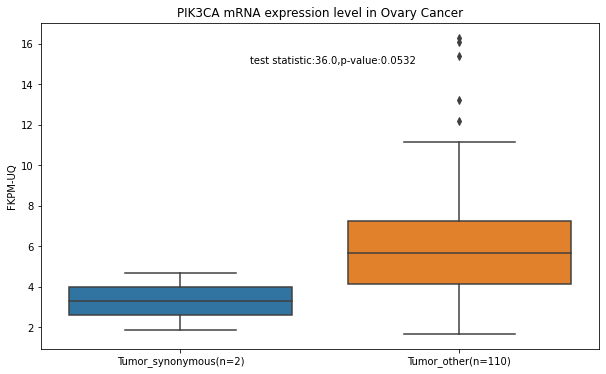

In [81]:
### Parameter card
gene_name = 'PIK3CA'
gene_id = sig_genes_syn.loc[sig_genes_syn[sig_genes_syn['gene_name'] == gene_name].index,'gene_id'].tolist()[0]

organ_type = 'Ovary'
organ_subtype = None
df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
syn_patients, syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


# Get expression and combine tumor, syn and normal df
df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_syn,df_other])
print(df_syn)

fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
ax.set_title(organ_type+'_'+gene_name)
mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.set_xticklabels([f'Tumor_synonymous(n={len(syn_test)})', f'Tumor_other(n={len(other_test)})'])
ax.set_xlabel('')
ax.set_ylabel('FKPM-UQ')
ax.set_title(gene_name+' mRNA expression level in '+organ_type+' Cancer')
props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
ax.annotate(text, xy=(0.25,15), zorder=10)

In [78]:
syn_mut_df

,Hugo_Symbol,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,...,i_signature_R1,i_signature_R2,i_snv_near_indel,t_alt_count,t_ref_count,i_model_score,i_n_vaf,Project_Code,Donor_ID,categ
69641,PIK3CA,3,178916901,178916901,+,Silent,SNP,A,A,G,...,False,False,False,13.0,151.0,NaN,NaN,Ovary-AdenoCA,DO28093,5
227258,PIK3CA,3,178928344,178928344,+,Silent,SNP,C,C,T,...,False,False,False,9.0,31.0,NaN,NaN,Ovary-AdenoCA,DO28273,1
938117,PIK3CA,3,178947156,178947156,+,Silent,SNP,C,C,T,...,False,False,False,12.0,21.0,NaN,NaN,Ovary-AdenoCA,DO46328,1


/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,17,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


['DO25797', 'DO25189']
['Silent']
['Silent']
['DO25797', 'DO25189']
                                     id       exp tumor.normal
0  ea55c131-97f8-49cc-a445-87523ce1f075  0.082308    tumor_syn
1  a1022e37-586a-4c6a-a754-01709bad7a43  0.100132    tumor_syn


Text(1, 1, '')

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/matplotlib/patches.py:3049: RuntimeWarning: invalid value encountered in double_scalars
  ddx, ddy = dx / dd, dy / dd


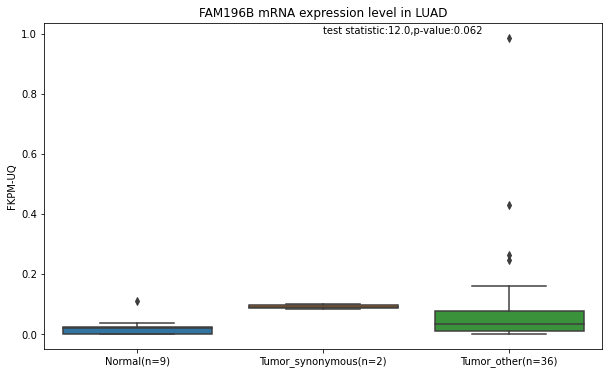

In [83]:
### Parameter card
gene_name = 'FAM196B'
gene_id = sig_genes_syn.loc[sig_genes_syn[sig_genes_syn['gene_name'] == gene_name].index,'gene_id'].tolist()[0]

organ_type = 'Lung'
organ_subtype = 'Lung-AdenoCA'
df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
syn_patients, syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


# Get expression and combine tumor, syn and normal df
df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_syn,df_other])
print(df_syn)


fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
ax.set_title(organ_type+'_'+gene_name)
mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.set_xticklabels([f'Normal(n={len(normal_test)})', f'Tumor_synonymous(n={len(syn_test)})', f'Tumor_other(n={len(other_test)})'])
ax.set_xlabel('')
ax.set_ylabel('FKPM-UQ')
ax.set_title(gene_name+' mRNA expression level in LUAD')
props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
ax.annotate(text, xy=(1,1), zorder=10)
ax.annotate('', xy=(1,1), xytext=(1,1), arrowprops=props)

/opt/aci/sw/anaconda3/2020.07_gcc-4.8.5-khh/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1,17,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


['DO6432', 'DO52718', 'DO27805', 'DO52651', 'DO52671', 'DO52685', 'DO52695', 'DO27857', 'DO52690', 'DO52652', 'DO27859', 'DO27809', 'DO52693', 'DO52694', 'DO52664', 'DO27773', 'DO52650', 'DO52677', 'DO52663', 'DO52647', 'DO27801', 'DO27797', 'DO52653', 'DO52689', 'DO52669', 'DO27781', 'DO27785', 'DO52655']
['Intron' 'Silent' "5'UTR" 'De_novo_Start_InFrame' "5'Flank"]
['Intron' 'Silent' "5'UTR" "5'Flank"]
['Intron' 'Silent' "5'UTR"]
['Intron' 'Silent' "5'UTR"]
['IGR' 'Intron' 'Silent' 'Missense_Mutation' "5'UTR" "5'Flank"]
['Intron' 'Silent' 'Missense_Mutation' "5'UTR" 'De_novo_Start_OutOfFrame'
 "5'Flank"]
['Intron' 'Missense_Mutation' 'Silent' "5'UTR"]
['Intron' 'Missense_Mutation' 'Silent' "5'UTR" "5'Flank"]
['Intron' 'Silent' 'Missense_Mutation' "5'UTR" 'De_novo_Start_OutOfFrame'
 "5'Flank"]
["3'UTR" 'Intron' 'Silent' "5'UTR" "5'Flank"]
["3'UTR" 'Intron' 'Silent' "5'UTR" "5'Flank"]
['Intron' 'Missense_Mutation' 'Silent' "5'UTR" "5'Flank"]
['Intron' 'Missense_Mutation' 'Silent' "5'UT

Text(0.25, 15, 'test statistic:527.0,p-value:0.0635')

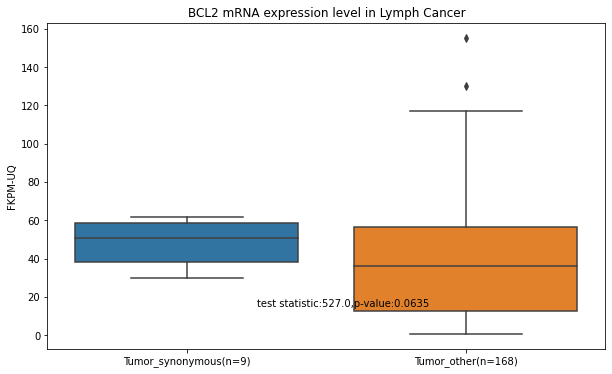

In [85]:
### Parameter card
gene_name = 'BCL2'
gene_id = sig_genes_syn.loc[sig_genes_syn[sig_genes_syn['gene_name'] == gene_name].index,'gene_id'].tolist()[0]

organ_type = 'Lymph'
organ_subtype = None
df_exp_gene = get_gene_exp(gene_id, df_exp_uq)
syn_patients, syn_mut_df = get_cancer_patients(organ_type, gene_name, subtype = organ_subtype)
id_normal, id_syn, id_other = get_patient_id(organ_type, syn_patients, subtype = organ_subtype)


# Get expression and combine tumor, syn and normal df
df_normal, normal_test = get_patient_exp(id_normal, df_exp_gene, 'normal')
df_syn, syn_test = get_patient_exp(id_syn, df_exp_gene,'tumor_syn')
df_other, other_test = get_patient_exp(id_other, df_exp_gene, 'tumor_other')
df_all = pd.concat([df_normal,df_syn,df_other])
print(df_syn)

fig,ax = plt.subplots(figsize=(10,6))
ax = sns.boxplot(x = 'tumor.normal', y = 'exp', data = df_all)
ax.set_title(organ_type+'_'+gene_name)
mannwhitneyu(syn_test, other_test)
text = f'test statistic:{round(mannwhitneyu(syn_test, other_test)[0],4)},p-value:{round(mannwhitneyu(syn_test, other_test)[1],4)}'
ax.set_xticklabels([f'Tumor_synonymous(n={len(syn_test)})', f'Tumor_other(n={len(other_test)})'])
ax.set_xlabel('')
ax.set_ylabel('FKPM-UQ')
ax.set_title(gene_name+' mRNA expression level in '+organ_type+' Cancer')
props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
ax.annotate(text, xy=(0.25,15), zorder=10)